In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

import os
os.environ['PROJ_LIB'] = r'C:\Users\aidan\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

In [7]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip (133.1 MB)
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 71, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 104, in main
    return self._main(args)
  File "/usr/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "

In [63]:
df = pd.read_csv('US_Accidents_Dec20_updated.csv')
df = df[df['Start_Lat'].notna()]
df = df[df['Start_Lng'].notna()]
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2716600,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2716601,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.86542,-84.06280,39.86501,-84.04873,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-2716602,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10266,-84.52468,39.10209,-84.52396,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-2716603,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10148,-84.52341,39.09841,-84.52241,0.219,At I-71/US-50/Exit 1 - Accident.,NaN,US-50 E,R,Cincinnati,Hamilton,OH,45202,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
4,A-2716604,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.06213,-81.53784,41.06217,-81.53547,0.123,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,10.0,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day


In [66]:
print('The length of the data is ' + str(len(df)))

The length of the data is 1516064


# Clustering

In [67]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
coords = df[['Start_Lat', 'Start_Lng']].values
kms_per_radian = 6371.0088
# half mile radius with minimum 10 accidents
# .4 km = .25 miles
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
cluster_labels = cluster_labels.astype(float)
cluster_labels[cluster_labels == -1] = np.nan
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

In [68]:
non_empty_clusters = pd.Series([cluster for cluster in clusters.values if len(cluster) != 0])

In [69]:
# https://stackoverflow.com/questions/64814999/getting-the-center-point-of-a-cluster-for-latitude-and-longitude-in-python
#noise_pts = pd.Series([coords[cluster_labels == -1]])
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = non_empty_clusters.map(get_centermost_point)


In [ ]:
# max_list = []
# min_list = []
# for cluster in clusters:
#   if len(cluster.flatten()) != 0:
#     max_list.append(np.array(cluster.flatten()).max())
#     min_list.append(np.array(cluster.flatten()).min())

# print(np.array(max_list).max())
# print(np.array(min_list).min())

In [ ]:
# len_list = []
# for cluster in clusters:
#     len_list.append(len(cluster))
# print(np.array(len_list).max())

In [72]:
# df[['Start_Lng']].max()

In [73]:
print("There are {} clusters.".format(len(non_empty_clusters)))

There are 17134 clusters.


In [74]:
# get the closest point to the centroid of each clsuter
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rs = rep_points.apply(lambda row: df[(df['Start_Lat']==row['lat']) & (df['Start_Lng']==row['lon'])].iloc[0], axis=1)


In [ ]:
rs

In [95]:
# downside of DBSCAN is that it assumes that all clusters will have similar density which is not necessarily the case here with the accident data as it will vary based on the population density of the area

print("Cluster to dataset length ratio: {}".format(len(non_empty_clusters)/len(df)))


Cluster to dataset length ratio: 0.011301633704118031


In [ ]:
# see this article for getting center point of clusters and getting original DF rows to get the severity https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
# DBSCAN on 1.5M row dataset https://github.com/gboeing/data-visualization/blob/main/location-history/google-location-history-cluster.ipynb

# PARAMS TO TWEAK:
# The radius defines the area of interest (shape, size) around each point and the
# minimum density threshold sets the minimum number of points which must fall within
# this area for it to be considered dense. They can be thought of as the maximum spread
# and minimum density associated with each point. 
# points not included in a cluster are labeled as cluster -1

In [ ]:
rs

In [ ]:
df['label'] = cluster_labels
avg_severity_by_cluster = df.groupby('label')['Severity'].mean().values

In [80]:
len(rs)

17134

In [81]:
rs['avg_severity'] = avg_severity_by_cluster

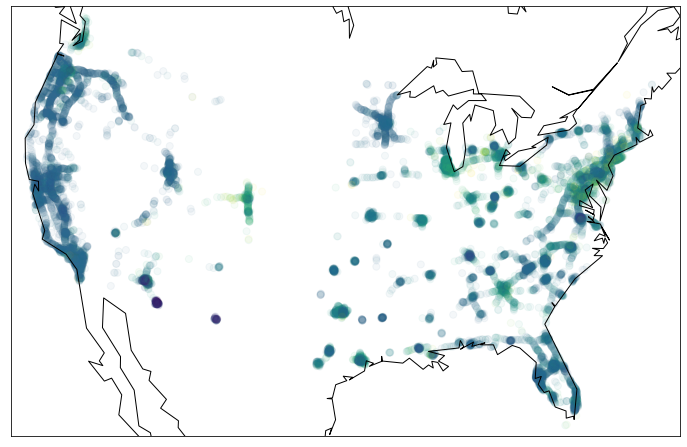

In [82]:
# compute the average severity rating for each cluster and plot the color on the map using this
fig = plt.figure(figsize=(12,9))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.drawcoastlines()
m.scatter(rs['Start_Lng'].values, rs['Start_Lat'].values, c = rs['avg_severity'], s = 50, latlon=True, alpha = 0.05)

In [83]:
rs

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,avg_severity
0,A-2826217,2,2016-04-08 09:47:13,2016-04-08 15:47:13,40.109090,-83.087220,40.109300,-83.095620,0.444,At Sawmill Rd/Exit 20 - Accident.,NaN,Outerbelt W,R,Columbus,Franklin,OH,43235,US,US/Eastern,KOSU,2016-04-08 09:53:00,37.0,28.9,65.0,29.84,10.0,WNW,12.7,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2.218182
1,A-3477732,2,2020-05-07 14:40:32,2020-05-07 15:25:32,39.099460,-84.515870,39.099220,-84.517500,0.089,At US-27/US-52/US-127/Central Ave - Accident.,400.0,Elm St,R,Cincinnati,Hamilton,OH,45202,US,US/Eastern,KLUK,2020-05-07 14:53:00,68.0,68.0,35.0,29.46,10.0,WNW,15.0,0.0,Mostly Cloudy,False,False,True,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,2.376940
2,A-2716824,2,2016-02-16 09:54:12,2016-02-16 15:54:12,41.062570,-81.522280,41.062680,-81.519880,0.125,At Wolf Ledges/Exit 22 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-16 09:54:00,34.0,28.8,89.0,29.72,1.2,NNW,5.8,0.0,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2.316279
3,A-2794698,2,2016-08-18 10:55:26,2016-08-18 16:55:26,39.181485,-84.484882,39.186929,-84.482240,0.402,Between OH-562/Exit 7 and OH-4/Paddock Rd/Exit...,NaN,I-75 N,R,Cincinnati,Hamilton,OH,45237,US,US/Eastern,KLUK,2016-08-18 10:53:00,77.0,NaN,82.0,30.13,7.0,Calm,NaN,NaN,Scattered Clouds,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2.290000
4,A-3457361,2,2020-06-01 11:50:43,2020-06-01 12:35:43,39.760280,-84.196450,39.760280,-84.196450,0.000,At W 3rd St - Accident.,298.0,W 2nd St,L,Dayton,Montgomery,OH,45402-1412,US,US/Eastern,KFFO,2020-06-01 11:56:00,65.0,65.0,46.0,29.43,10.0,SW,5.0,0.0,Fair,False,False,True,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,2.175243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17129,A-4234578,2,2019-08-13 14:10:19,2019-08-13 18:10:19,45.753464,-120.153616,45.762447,-120.129502,1.318,At OR-74/Exit 147 - Accident.,NaN,I-84 E,R,Arlington,Gilliam,OR,97812,US,US/Pacific,KHRI,2019-08-13 13:53:00,89.0,89.0,22.0,29.36,10.0,NE,8.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2.000000
17130,A-4131682,2,2017-10-10 17:47:41,2017-10-10 23:47:41,32.997615,-80.670091,33.016968,-80.665862,1.359,Between SC-64/Exit 57 and SC-61/Exit 68 - Acci...,NaN,I-95 N,R,Walterboro,Colleton,SC,29488,US,US/Eastern,KRBW,2017-10-10 17:55:00,78.8,NaN,94.0,30.07,10.0,ESE,4.6,NaN,Scattered Clouds,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2.200000
17131,A-4235370,4,2019-08-15 15:54:19,2019-08-15 16:22:32,39.430550,-87.330237,39.445700,-87.239590,4.949,Closed between US-150/US-41/Exit 7 and IN-59/E...,NaN,I-70 E,R,Terre Haute,Vigo,IN,47802,US,US/Eastern,KHUF,2019-08-15 15:53:00,82.0,82.0,52.0,29.37,10.0,W,9.0,0.0,Partly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2.923077
17132,A-3451237,2,2020-05-28 06:56:37,2020-05-28 09:16:35,44.024730,-116.944670,44.024730,-116.944670,0.000,At I-84/US-30/Old Oregon Trail Hwy - Accident.,1305.0,E Idaho Ave,R,Ontario,Malheur,OR,97914-3022,US,US/Mountain,KONO,2020-05-28 06:53:00,55.0,NaN,62.0,27.78,10.

In [84]:
import json

cluster_data = []
for idx, row in rs.iterrows():
  cluster_dict = {'cluster_id': idx, 'centroid_latitude': row['Start_Lat'], 'centroid_longitude': row['Start_Lng'], 'avg_severity': row['avg_severity']}
  cluster_data.append(cluster_dict)

In [85]:
with open('accident_hotspots.json', 'w') as file:
     file.write(json.dumps(cluster_data))

In [86]:
len(rs)

17134

In [87]:
len(non_empty_clusters)

17134

In [88]:
len(cluster_labels)

1516064

In [89]:
len(df)

1516064

In [90]:
out_df = df[df['label'] != -1]
out_df = df[~df['label'].isna()]
lat = out_df['Start_Lat'].values
long = out_df['Start_Lng'].values
cluster = out_df['label'].values

out_list = []
for point in zip(lat,long,cluster):
  temp_dict = {'latitude':point[0], 'longitude':point[1], 'cluster_assignment': point[2]}
  out_list.append(temp_dict)




In [91]:
len(df)

1516064

In [92]:
out_list[0]

{'cluster_assignment': 0.0,
 'latitude': 40.108909999999995,
 'longitude': -83.09286}

In [96]:
len(out_list)

1178659

In [93]:
with open('cluster_assignments.json', 'w') as file:
     file.write(json.dumps(out_list))

In [97]:
from google.colab import files
files.download('accident_hotspots.json')
files.download('cluster_assignments.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
clusters_compressed = []
for i, points in enumerate(non_empty_clusters.values):
  temp_compressed = {'cluster_id': i, 'points': points}
  clusters_compressed.append(temp_compressed)
